In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/GregaVrbancic/Phishing-Dataset/master/dataset_full.csv', nrows=40000)

In [3]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


## EDA and Data Check

In [207]:
#no categorical values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 34.2 MB


In [4]:
#no missing values
assert df.isna().agg(sum).sum() == 0

In [5]:
#checking for dulplicate rows
df.duplicated().sum()

454

In [6]:
#dropping duplicate rows
df = df.drop_duplicates(keep=False)

In [7]:
assert df.duplicated().sum() == 0

In [8]:
df.shape

(39337, 112)

In [9]:
#moderately imbalanced dataset
df.phishing.value_counts(normalize=True)

phishing
0    0.64977
1    0.35023
Name: proportion, dtype: float64

## Variance in dataset sections

The entire dataset was devided into the following sections:
- Dataset attributes based on URL
- Dataset attributes based on Domain URL
- Dataset attributes based on URL directory
- Dataset attributes based on URL file name
- Dataset attributes based on URL parameters
- Dataset attributes based on resolving URL and external services

So it makes sense to check how these sections might be different

In [214]:
df_copy = df.copy()

In [215]:
#Let's create a separate dataframe for each section
df_url = df_copy.iloc[:, :19].assign(email_in_url=df_copy['email_in_url'])
df_domain = df_copy.iloc[:, 19:40]
df_directory = df_copy.iloc[:, 40:58]
df_file = df_copy.iloc[:, 58:76]
df_param = df_copy.iloc[:, 76:96]
df_external = df_copy.iloc[:, 97:111]

In [216]:
#We will exclude the last section from comparision becuase it contains data of a different kind
dataframes = [df_url, df_domain, df_directory, df_file, df_param]
df_names = ['URL', 'Domain', 'Directory', 'File', 'Parameter']

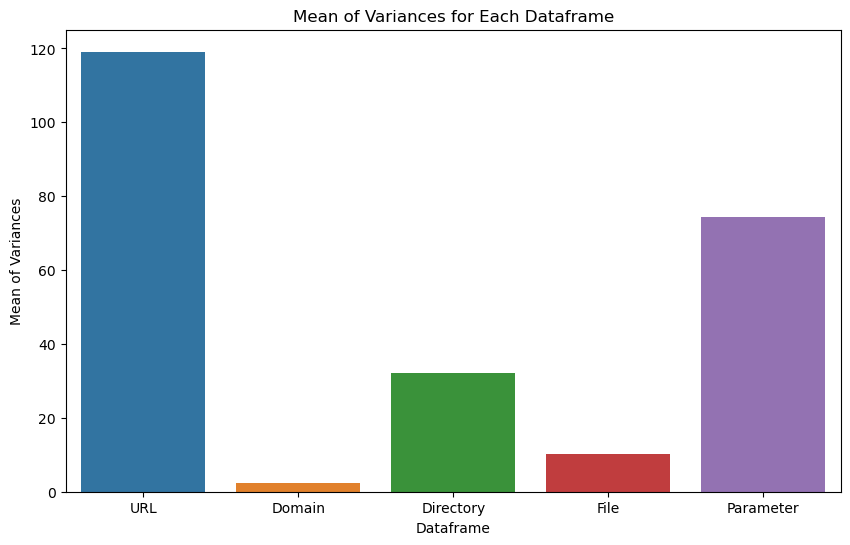

In [217]:
#Let's calculate mean values of variances for all sections and plot the result
results = []
for df_copy, name in zip(dataframes, df_names):
    result = df_copy.var().mean()
    results.append({'Dataframe': name, 'Variance Mean': result})
result_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataframe', y='Variance Mean', data=result_df)
plt.title('Mean of Variances for Each Dataframe')
plt.xlabel('Dataframe')
plt.ylabel('Mean of Variances')
plt.show()

In [9]:
#As we can see, the domain section has near zero mean variance which might indicate its less importance

## mutual_info_classif

In [218]:
X = df.drop('phishing', axis=1)
y = df['phishing']

In [219]:
mi_scores = mutual_info_classif(X, y)

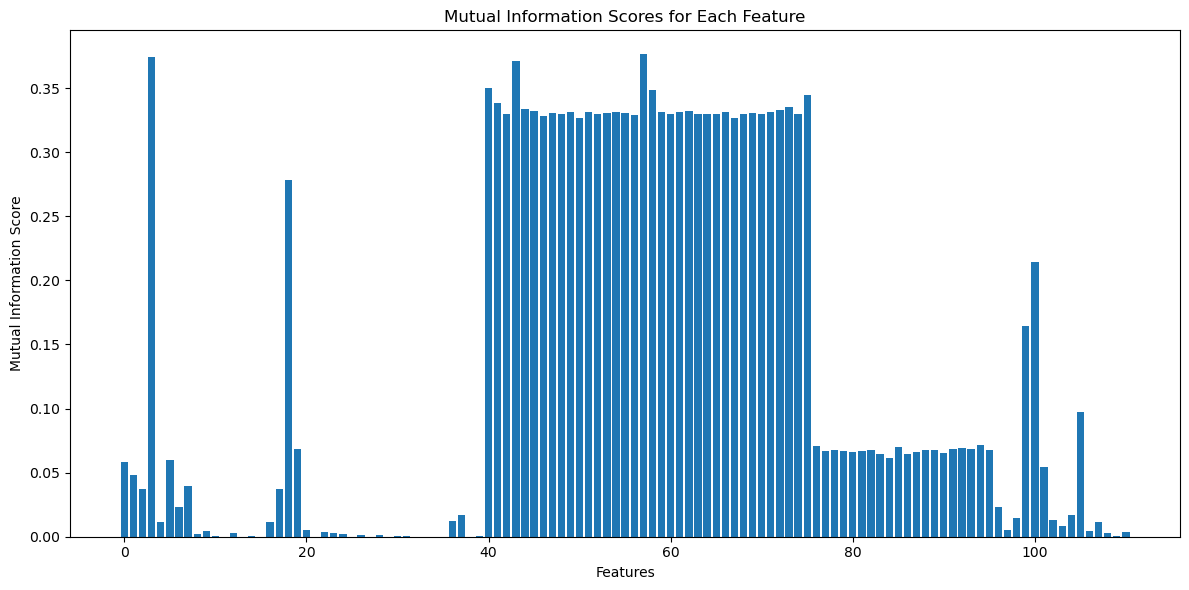

In [220]:
# Create a bar plot of mutual information scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(mi_scores)), mi_scores)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Each Feature')
#plt.xticks(range(len(mi_scores)), X.columns, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [221]:
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False).reset_index(drop=True)
print("\nFeatures ranked by Mutual Information Score:")
print(mi_df)


Features ranked by Mutual Information Score:
                 Feature  MI_Score
0       directory_length  0.376233
1          qty_slash_url  0.374629
2    qty_slash_directory  0.371218
3      qty_dot_directory  0.349941
4           qty_dot_file  0.348710
..                   ...       ...
106     qty_tilde_domain  0.000000
107        qty_at_domain  0.000000
108        qty_comma_url  0.000000
109     qty_asterisk_url  0.000000
110       qty_dollar_url  0.000000

[111 rows x 2 columns]


In [222]:
mi_df.query('MI_Score > 0.01')

,Feature,MI_Score
0,directory_length,0.376233
1,qty_slash_url,0.374629
2,qty_slash_directory,0.371218
3,qty_dot_directory,0.349941
4,qty_dot_file,0.348710
...,...,...
74,qty_ip_resolved,0.013116
75,qty_vowels_domain,0.012598
76,qty_questionmark_url,0.011695
77,qty_percent_url,0.011508


([], [])

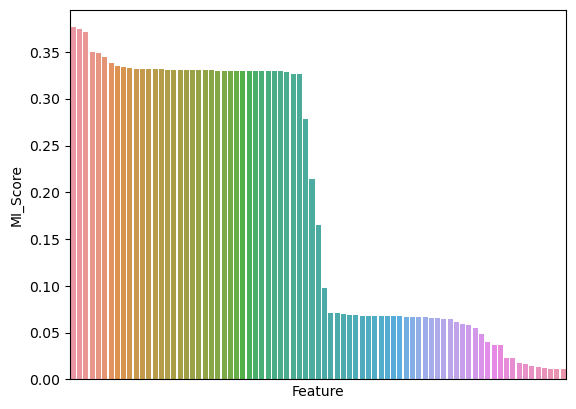

In [223]:
sns.barplot(x='Feature', y='MI_Score', data=mi_df.query('MI_Score > 0.01'))
plt.xticks([])

In [224]:
mi_df.query('MI_Score < 0.01')

,Feature,MI_Score
79,qty_nameservers,0.008674
80,time_response,0.005172
81,qty_hyphen_domain,0.004987
82,tls_ssl_certificate,0.004520
83,qty_space_url,0.004282
84,url_shortened,0.003600
85,qty_slash_domain,0.003317
86,url_google_index,0.003043
87,qty_plus_url,0.002981
88,qty_questionmark_domain,0.002575


## Multicollinearity

**The dataset has a high degree of multicollinearity, however, we will not do anything about it**

In [225]:
corr_matrix = df.corr()

In [226]:
threshold = 0.8

In [227]:
#Create a mask to ignore self-correlations (diagonal) and lower triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

In [228]:
#Extract pairs of features with correlation greater than the threshold
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                   for i, j in zip(*np.where((np.abs(corr_matrix) > threshold) & mask))]

In [229]:
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

In [230]:
high_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature 1    502 non-null    object 
 1   Feature 2    502 non-null    object 
 2   Correlation  502 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.9+ KB


## PCA

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [232]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [233]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [234]:
# Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 37


## Data prep

In [10]:
X = df.drop(labels=["phishing"], axis=1)
y = df["phishing"]

In [11]:
#train/test splitting with stratify option
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

((31469, 111), (7868, 111))

In [12]:
#standard scaling
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## About accuracy metric

For this dataset, a false positive will be observed when a model labels a normal site as malicious. A false negative will be observed when a model labels a malicious site. False negatives are more dangerous as a user will trust a malicious site. Therefore, we will be using recall score.

## Aplying models

**Dummy classifier**

In [13]:
#We will use a sklearn dummy classifier to establish a baseline
dummy_clf = DummyClassifier(strategy="prior")

In [14]:
dummy_clf.fit(X_train_scaled, y_train)

DummyClassifier()

In [15]:
y_pred_test = dummy_clf.predict(X_test_scaled)
y_pred_train = dummy_clf.predict(X_train_scaled)

In [16]:
#the dummy classifer predicts no instance of 1 class, therefore we can't really calculate false negative rate or 
#recall score
np.unique(y_pred_test)

array([0])

In [17]:
auc_roc_test_dummy = roc_auc_score(y_test, y_pred_test)
auc_roc_train_dummy = roc_auc_score(y_train, y_pred_train)
print("Test set AUC-ROC score: ", round(auc_roc_test_dummy, 3))
print("Train set AUC-ROC score: ", round(auc_roc_train_dummy, 3))

Test set AUC-ROC score:  0.5
Train set AUC-ROC score:  0.5


In [248]:
#0.5 indicates random guessing

In [18]:
#we can look at the classification report to confirm that
report = classification_report(y_test, y_pred_test, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.65      1.00      0.79      5112
           1       0.00      0.00      0.00      2756

    accuracy                           0.65      7868
   macro avg       0.32      0.50      0.39      7868
weighted avg       0.42      0.65      0.51      7868



In [19]:
#function to calculate scores
def calculate_scores(model):
    recall_test = recall_score(y_test, model.predict(X_test_scaled))
    recall_train = recall_score(y_train, model.predict(X_train_scaled))
    
    auc_roc_test = roc_auc_score(y_test, model.predict(X_test_scaled))
    auc_roc_train = roc_auc_score(y_train, model.predict(X_train_scaled))
    
    print("Test set recall score: ", round(recall_test, 3))
    print("Train set recall score: ", round(recall_train, 3))
    print("Test set AUC-ROC score: ", round(auc_roc_test, 3))
    print("Train set AUC-ROC score: ", round(auc_roc_train, 3))
    
    return recall_test, recall_train, auc_roc_test, auc_roc_test 

**Logistic regression**

In [245]:
log_reg = LogisticRegression(max_iter=10000)

In [246]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000)

In [247]:
calculate_scores(log_reg)

Test set recall score:  0.915
Train set recall score:  0.917
Test set AUC-ROC score:  0.928
Train set AUC-ROC score:  0.93


(0.9150943396226415,
 0.9168859450140641,
 0.9280088286532613,
 0.9280088286532613)

**KNN**

In [249]:
knn = KNeighborsClassifier()

In [250]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [253]:
calculate_scores(knn)

Test set recall score:  0.917
Train set recall score:  0.944
Test set AUC-ROC score:  0.938
Train set AUC-ROC score:  0.958


(0.9169085631349783,
 0.9435622901733055,
 0.9378165663875204,
 0.9378165663875204)

**Decision Tree**

In [254]:
decision_tree = DecisionTreeClassifier()

In [255]:
decision_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [256]:
calculate_scores(decision_tree)

Test set recall score:  0.91
Train set recall score:  1.0
Test set AUC-ROC score:  0.933
Train set AUC-ROC score:  1.0


(0.910377358490566, 0.9998185282642228, 0.932594782531668, 0.932594782531668)

**SVM**

In [257]:
svc = SVC()

In [258]:
svc.fit(X_train_scaled, y_train)

SVC()

In [259]:
calculate_scores(svc)

Test set recall score:  0.926
Train set recall score:  0.931
Test set AUC-ROC score:  0.936
Train set AUC-ROC score:  0.942


(0.9256168359941945,
 0.9313129480083477,
 0.9357153037560957,
 0.9357153037560957)

**Random forrest**

In [262]:
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [263]:
calculate_scores(rf)

Test set recall score:  0.95
Train set recall score:  1.0
Test set AUC-ROC score:  0.958
Train set AUC-ROC score:  1.0


(0.9499274310595065,
 0.9998185282642228,
 0.9577493180336656,
 0.9577493180336656)

**XG Boost**

In [20]:
xg = xgb.XGBClassifier(seed=123)

In [21]:
xg.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
calculate_scores(xg)

Test set recall score:  0.951
Train set recall score:  0.981
Test set AUC-ROC score:  0.962
Train set AUC-ROC score:  0.986


(0.9510159651669086,
 0.9806732601397332,
 0.9616190936945654,
 0.9616190936945654)

## Tuning the model

In [127]:
param_grid_knn = {
    'n_neighbors': [18, 19, 20, 21, 22],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [128]:
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='recall')

In [129]:
grid_search_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [18, 19, 20, 21, 22],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [130]:
best_knn = grid_search_knn.best_estimator_

In [131]:
y_pred_test_knn_g = best_knn.predict(X_test_scaled)
y_pred_train_knn_g = best_knn.predict(X_train_scaled)

In [132]:
recall_test_knn_g = recall_score(y_test, y_pred_test_knn_g)
recall_train_knn_g = recall_score(y_train, y_pred_train_knn_g)

In [133]:
print("Best parameters found: ", grid_search_knn.best_params_)

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


In [134]:
print("Test set recall score: ", round(recall_test_knn_g, 3))
print("Train set recall score: ", round(recall_train_knn_g, 3))

Test set recall score:  0.931
Train set recall score:  1.0


## Feature selection

In [139]:
sfs = SequentialFeatureSelector(knn, n_features_to_select=10, direction='backward', scoring='recall')

In [143]:
pipeline = Pipeline([
    ('feature_selection', sfs),
    ('KNN', knn)
])

In [144]:
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('feature_selection',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=KNeighborsClassifier(),
                                           n_features_to_select=10,
                                           scoring='recall')),
                ('KNN', KNeighborsClassifier())])

In [145]:
y_pred_test_knn_2 = pipeline.predict(X_test_scaled)
y_pred_train_knn_2 = pipeline.predict(X_train_scaled)

In [146]:
recall_test_knn_2 = recall_score(y_test, y_pred_test_knn_2)
recall_train_knn_2 = recall_score(y_train, y_pred_train_knn_2)

In [147]:
print("Test set recall score: ", round(recall_test_knn_2, 3))
print("Train set recall score: ", round(recall_train_knn_2, 3))

Test set recall score:  0.906
Train set recall score:  0.947


In [148]:
selected_features = sfs.get_support(indices=True)

In [149]:
print(f'Selected Features: {X.columns[selected_features].tolist()}')

Selected Features: ['qty_slash_url', 'qty_dot_domain', 'qty_vowels_domain', 'qty_dot_directory', 'qty_underline_file', 'domain_spf', 'time_domain_activation', 'qty_ip_resolved', 'qty_mx_servers', 'tls_ssl_certificate']
